In [2]:
#import all necessary libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.express as px
import os
import cv2
import itertools
import tensorflow as tf
import pydot
import graphviz

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# Set the path to your training and validation data
train_path = "../data/train"
test_path = "../data/test"

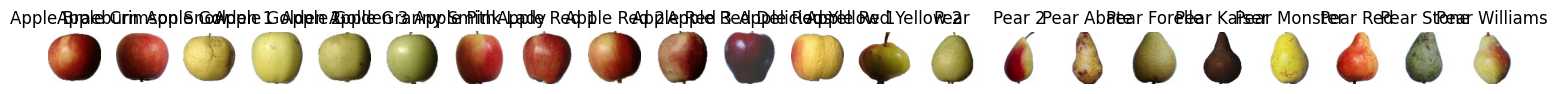

In [5]:
# Now we will navigate into the image folders to get the fruit images and then visualize the first image from different image folder.

# for folder in os.listdir(test_path):
#   sub_path = train_path +'/'+ folder

#   print(folder)
#   for i in range(1):
#     temp_path = os.listdir(sub_path)[1]
#     temp_path = sub_path +'/'+ temp_path
#     img = mpimg.imread(temp_path)
#     implot = plt.imshow(img)
#     plt.show()

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images_from_folders(folder_path):
    # Get a list of folders in the specified path
    folders = os.listdir(folder_path)
    
    # Create a figure with subplots for each folder
    num_folders = len(folders)
    fig, axes = plt.subplots(1, num_folders, figsize=(15, 5))
    
    # Iterate through each folder
    for idx, folder in enumerate(folders):
        sub_path = os.path.join(folder_path, folder)
        
        # Get the path of the first image file in the folder
        image_files = os.listdir(sub_path)
        if image_files:  # Check if the folder is not empty
            temp_path = os.path.join(sub_path, image_files[0])
            img = mpimg.imread(temp_path)
            
            # Plot the image in the corresponding subplot
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(f'{folder}')
    
    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()
# Example usage:

plot_images_from_folders(train_path)




In [9]:
# After reading the images, we then create a function to convert the images into an array.
def imagearray(path, size):
  data = []
  for folder in os.listdir(path):
    sub_path = path + "/" + folder

    for img in os.listdir(sub_path):
      image_path = sub_path + "/" + img
      img_arr = cv2.imread(image_path)
      img_arr = cv2.resize(img_arr, size)
      data.append(img_arr)
  return data

size = (224, 224)
train = imagearray(train_path, size)
images = np.array(train)
images = images/255
# x_test = np.array(test)

# print("x_train_shape", images.shape)

# The ImageGenerator is used for Data Augmentation, batch loading and class balancing
def data_class(data_path, size, class_mode):
  datagen = ImageDataGenerator(rescale = 1./255)
  classes = datagen.flow_from_directory(data_path,
                                        target_size = size,
                                        batch_size = 32,
                                        class_mode = class_mode)
  return classes

#this is used to get the classes for the image dataset and this classes will be alocated as labels for both the 
# training and validation data
train_class = data_class(train_path, size, 'sparse')

labels = train_class.classes
train_class.classes

# Now the feature (images) and labels (classes) are splited into train and test sets in the order of 80% and 20% respectively. Also, the split is generated randomly as specified in the code. 
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 1234)

In [15]:
train_class.class_indices

{'Apple Braeburn': 0,
 'Apple Crimson Snow': 1,
 'Apple Golden 1': 2,
 'Apple Golden 2': 3,
 'Apple Golden 3': 4,
 'Apple Granny Smith': 5,
 'Apple Pink Lady': 6,
 'Apple Red 1': 7,
 'Apple Red 2': 8,
 'Apple Red 3': 9,
 'Apple Red Delicious': 10,
 'Apple Red Yellow 1': 11,
 'Apple Red Yellow 2': 12,
 'Pear': 13,
 'Pear 2': 14,
 'Pear Abate': 15,
 'Pear Forelle': 16,
 'Pear Kaiser': 17,
 'Pear Monster': 18,
 'Pear Red': 19,
 'Pear Stone': 20,
 'Pear Williams': 21}

In [16]:
# Now the feature (images) and labels (classes) are splited into train and test sets in the order of 80% and 20% respectively. Also, the split is generated randomly as specified in the code. 

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 1234)

In [17]:
print("y_train_shape", y_train.shape,
      "x_train_shape", x_train.shape,
      "y_test_shape", y_test.shape,
      "x_test_shape", x_test.shape)

y_train_shape (2920,) x_train_shape (2920, 224, 224, 3) y_test_shape (731,) x_test_shape (731, 224, 224, 3)


In [18]:
y_train = to_categorical(y_train, num_classes = 22)
y_test = to_categorical(y_test, num_classes = 22)

# **VGG16 Model**

In [18]:
# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [19]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [20]:
# Create a new model
model = Sequential()
# Add the base model as a layer
model.add(base_model)

In [21]:
# Add custom layers on top of the base model
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [22]:
num_classes = 22

x = Flatten()(base_model.output)
prediction = Dense(num_classes, activation = 'sigmoid')(x)

In [23]:
model = Model(inputs = base_model.input, outputs = prediction)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 22)             │       551,958 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,266,646 (58.24 MB)

 Trainable params: 551,958 (2.11 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

In [26]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [27]:
history = model.fit(x_train, y_train, validation_split = 0.1, epochs = 20, callbacks = [early_stop], batch_size = 32, shuffle = True)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.4343 - loss: 0.2382 - val_accuracy: 0.9897 - val_loss: 0.0171
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9961 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - v

# **Accuracy** **Test**   

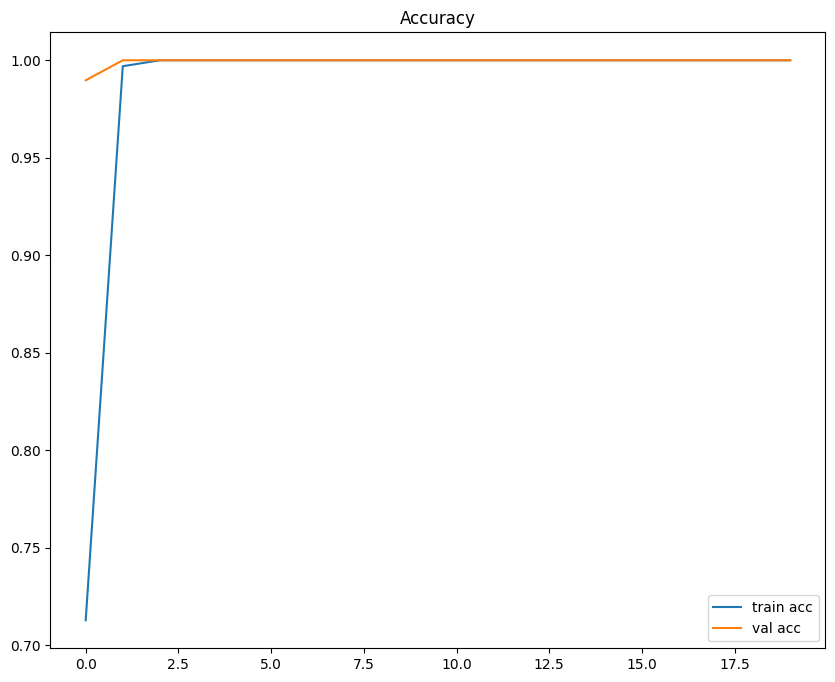

In [28]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

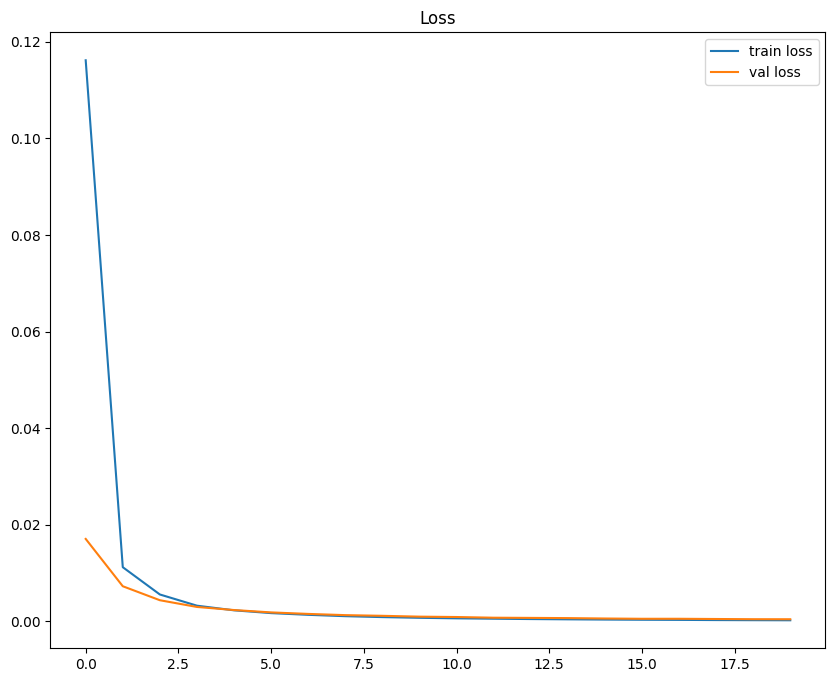

In [29]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

In [30]:
print(history.history['accuracy'][-1])
print(history.history['val_accuracy'][-1])
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

1.0
1.0
0.00023552925267722458
0.00044921733206138015


# **Model Evaluation**

In [31]:
model.evaluate(x_test, y_test, batch_size=32)

23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 1.0000 - loss: 3.8606e-04


[0.000455378059996292, 1.0]

In [32]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_train, y_train, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 1.0000 - loss: 3.8606e-04
92/92 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 1.0000 - loss: 2.2912e-04


Validation: accuracy = 1.000000  ;  loss_v = 0.000241
Test: accuracy = 1.000000  ;  loss = 0.000455


23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step
Precision: 0.9986320109439124
Recall: 0.9986320109439124
F1 score: 0.9986320109439124


C:\Users\LENOVO\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


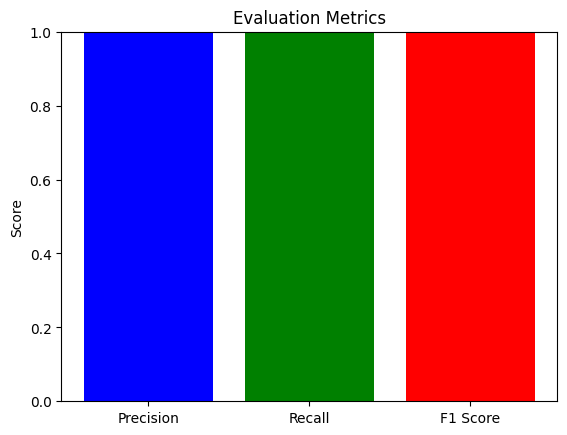

In [33]:
# from sklearn.metrics import precision_recall_fscore_support

# # load your test data and the predictions of the CNN model
# y_pred = model.predict(x_test) # shape: (num_samples,)

# # convert probabilities to class labels (0 or 1) based on a threshold of 0.5
# y_pred = np.round(y_pred).astype(int)

# # calculate precision, recall, and F1 score
# precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='samples')

# # print the results
# print('Precision:', precision)
# print('recall:', recall)
# print('F1 score:', f1_score)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# Assuming `model` is already defined and trained, and `x_test` and `y_test` are your test data and labels
y_pred = model.predict(x_test)  # shape: (num_samples, num_classes)

# Convert probabilities to class labels (0 or 1) based on a threshold of 0.5
y_pred = np.round(y_pred).astype(int)

# Calculate precision, recall, and F1 score using 'samples' averaging
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='samples')

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

# Plotting the results as a bar chart
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1_score]

plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylim(0, 1)  # Precision, recall, and F1 score values range from 0 to 1
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.show()



23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step


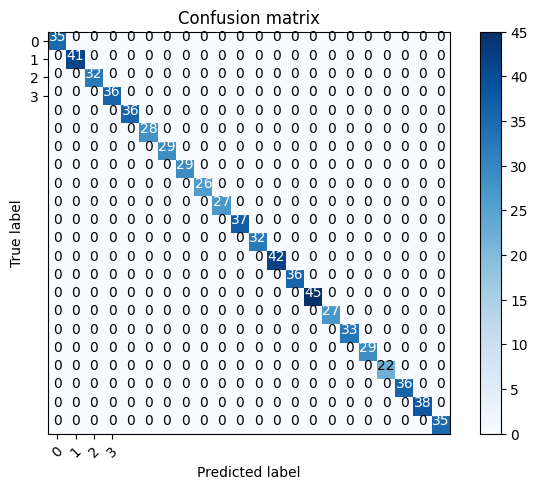

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4))

In [36]:
model.save("VGG16.h5")

Found 331 images belonging to 22 classes.
Found 330 images belonging to 22 classes.


C:\Users\LENOVO\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


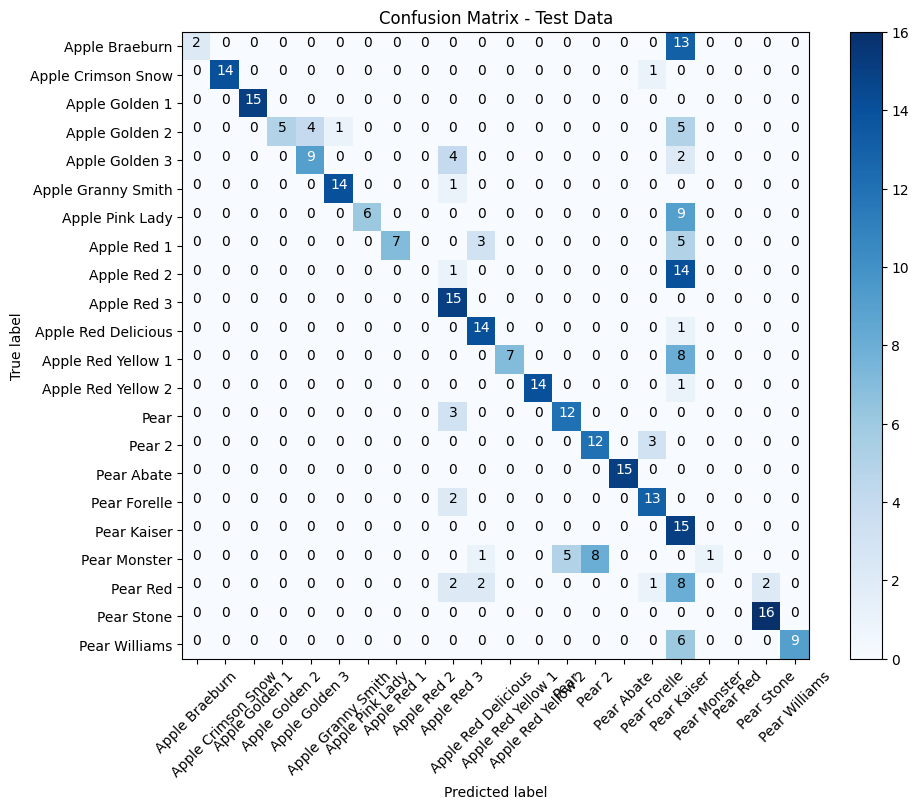

Classification Report - Test Data
                     precision    recall  f1-score   support

     Apple Braeburn       1.00      0.13      0.24        15
 Apple Crimson Snow       1.00      0.93      0.97        15
     Apple Golden 1       1.00      1.00      1.00        15
     Apple Golden 2       1.00      0.33      0.50        15
     Apple Golden 3       0.69      0.60      0.64        15
 Apple Granny Smith       0.93      0.93      0.93        15
    Apple Pink Lady       1.00      0.40      0.57        15
        Apple Red 1       1.00      0.47      0.64        15
        Apple Red 2       0.00      0.00      0.00        15
        Apple Red 3       0.54      1.00      0.70        15
Apple Red Delicious       0.70      0.93      0.80        15
 Apple Red Yellow 1       1.00      0.47      0.64        15
 Apple Red Yellow 2       1.00      0.93      0.97        15
               Pear       0.71      0.80      0.75        15
             Pear 2       0.60      0.80      0.69

C:\Users\LENOVO\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


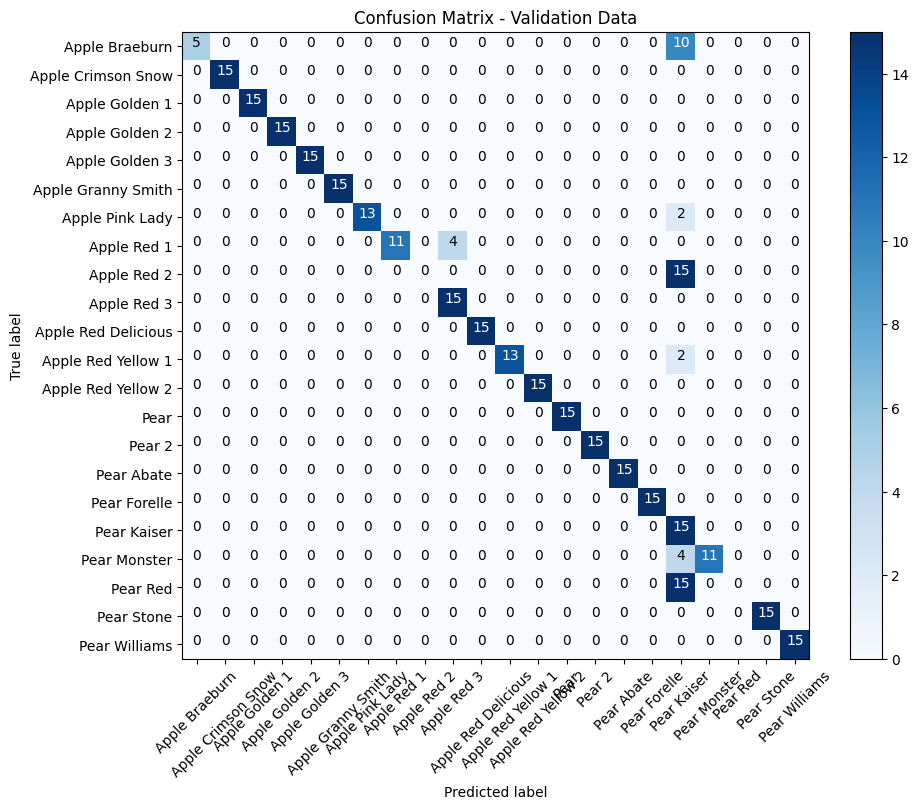

Classification Report - Validation Data
                     precision    recall  f1-score   support

     Apple Braeburn       1.00      0.33      0.50        15
 Apple Crimson Snow       1.00      1.00      1.00        15
     Apple Golden 1       1.00      1.00      1.00        15
     Apple Golden 2       1.00      1.00      1.00        15
     Apple Golden 3       1.00      1.00      1.00        15
 Apple Granny Smith       1.00      1.00      1.00        15
    Apple Pink Lady       1.00      0.87      0.93        15
        Apple Red 1       1.00      0.73      0.85        15
        Apple Red 2       0.00      0.00      0.00        15
        Apple Red 3       0.79      1.00      0.88        15
Apple Red Delicious       1.00      1.00      1.00        15
 Apple Red Yellow 1       1.00      0.87      0.93        15
 Apple Red Yellow 2       1.00      1.00      1.00        15
               Pear       1.00      1.00      1.00        15
             Pear 2       1.00      1.00    

C:\Users\LENOVO\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

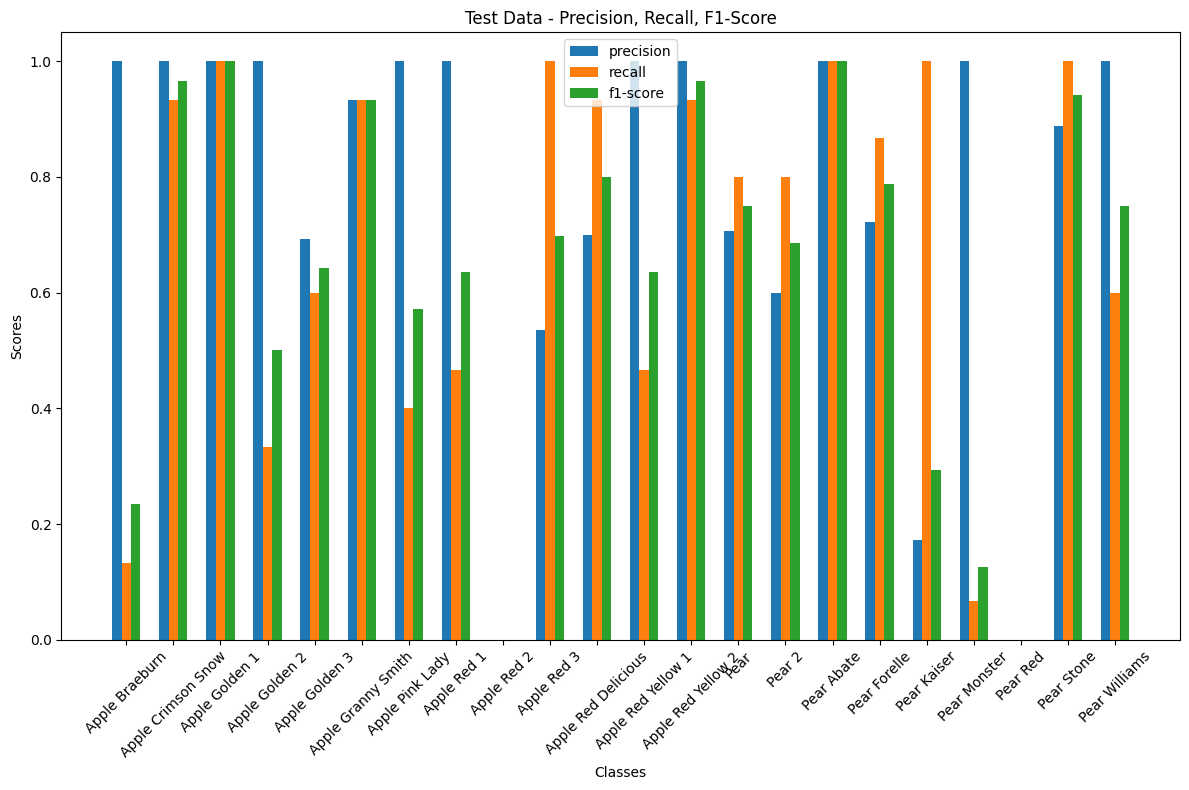

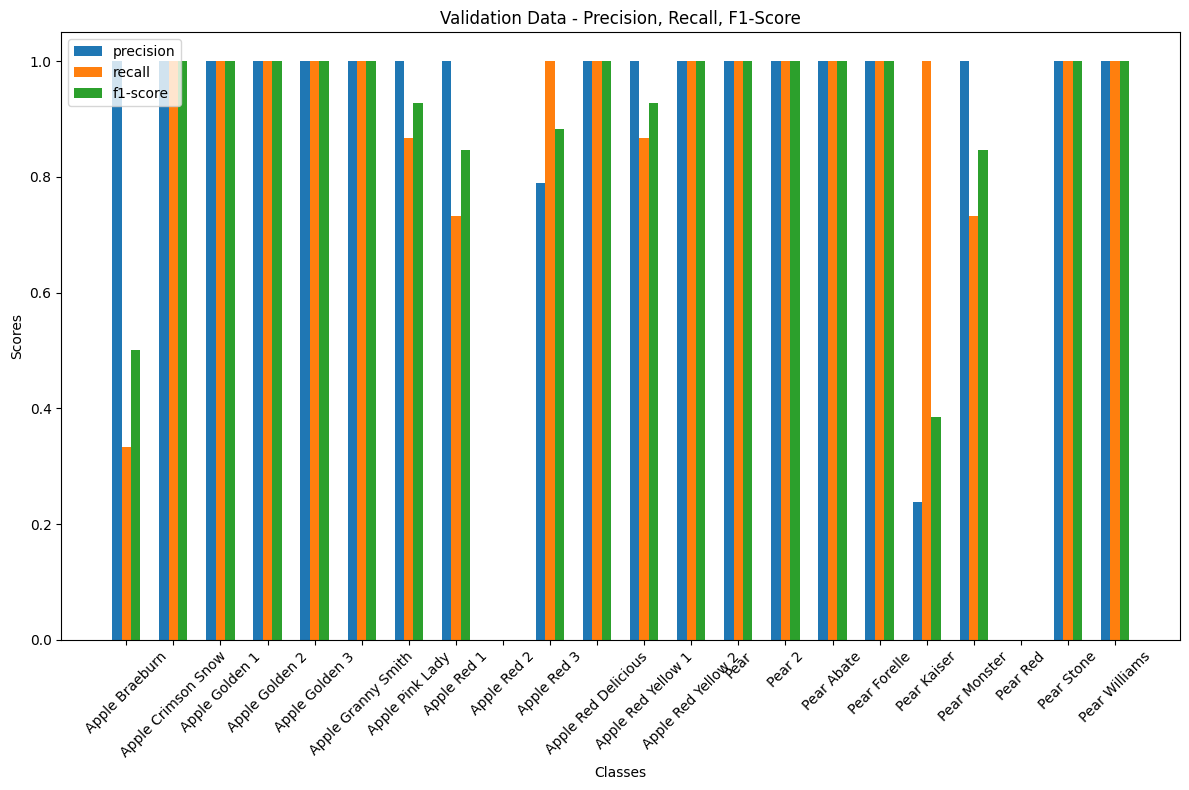

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('VGG16.h5')

# Set the paths to your dataset directories
test_data_dir = '../data/test'
val_data_dir = '../data/validation'

# Create a data generator for loading the data in batches
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load the test dataset
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load the validation dataset
val_generator = datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Predict the values from the test dataset
Y_pred_test = model.predict(test_generator)
Y_pred_classes_test = np.argmax(Y_pred_test, axis=1)
Y_true_test = test_generator.classes

# Compute the confusion matrix for the test dataset
confusion_mtx_test = confusion_matrix(Y_true_test, Y_pred_classes_test)

# Plot the confusion matrix for the test dataset
plot_confusion_matrix(confusion_mtx_test, classes=test_generator.class_indices.keys(), title='Confusion Matrix - Test Data')

# Print classification report for the test dataset
print("Classification Report - Test Data")
report_test = classification_report(Y_true_test, Y_pred_classes_test, target_names=list(test_generator.class_indices.keys()), output_dict=True)
print(classification_report(Y_true_test, Y_pred_classes_test, target_names=list(test_generator.class_indices.keys())))

# Predict the values from the validation dataset
Y_pred_val = model.predict(val_generator)
Y_pred_classes_val = np.argmax(Y_pred_val, axis=1)
Y_true_val = val_generator.classes

# Compute the confusion matrix for the validation dataset
confusion_mtx_val = confusion_matrix(Y_true_val, Y_pred_classes_val)

# Plot the confusion matrix for the validation dataset
plot_confusion_matrix(confusion_mtx_val, classes=val_generator.class_indices.keys(), title='Confusion Matrix - Validation Data')

# Print classification report for the validation dataset
print("Classification Report - Validation Data")
report_val = classification_report(Y_true_val, Y_pred_classes_val, target_names=list(val_generator.class_indices.keys()), output_dict=True)
print(classification_report(Y_true_val, Y_pred_classes_val, target_names=list(val_generator.class_indices.keys())))

# Plot precision, recall, and F1-score
def plot_metrics(report, title):
    metrics = ['precision', 'recall', 'f1-score']
    classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'

    scores = {metric: [report[cls][metric] for cls in classes] for metric in metrics}

    x = np.arange(len(classes))

    plt.figure(figsize=(12, 8))
    for metric in metrics:
        plt.bar(x + (metrics.index(metric) * 0.2), scores[metric], width=0.2, label=metric)

    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title(title)
    plt.xticks(x + 0.2, classes, rotation=45)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Plot the metrics for the test data
plot_metrics(report_test, 'Test Data - Precision, Recall, F1-Score')

# Plot the metrics for the validation data
plot_metrics(report_val, 'Validation Data - Precision, Recall, F1-Score')

# bobot model 
model.summary()

# Retrieve the weights for each layer
layer_weights = model.get_weights()

# Print the weights of each layer
for i, weight in enumerate(layer_weights):
    print(f'Layer {i} weights shape: {weight.shape}')
    print(weight)


In [26]:
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('model.h5')

# Print a summary of the model to see its layers and parameters
model.summary()

# Retrieve the weights for each layer
layer_weights = model.get_weights()

# Print the weights of each layer
for i, weight in enumerate(layer_weights):
    print(f'Layer {i} weights shape: {weight.shape}')
    print(weight)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 22)             │       551,958 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,266,648 (58.24 MB)

 Trainable params: 551,958 (2.11 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)

Layer 0 weights shape: (3, 3, 3, 64)
[[[[ 4.29470569e-01  1.17273867e-01  3.40129584e-02 ... -1.32241577e-01
    -5.33475243e-02  7.57738389e-03]
   [ 5.50379455e-01  2.08774377e-02  9.88311544e-02 ... -8.48205537e-02
    -5.11389151e-02  3.74943428e-02]
   [ 4.80015397e-01 -1.72696680e-01  3.75577137e-02 ... -1.27135560e-01
    -5.02991639e-02  3.48965675e-02]]

  [[ 3.73466998e-01  1.62062630e-01  1.70863140e-03 ... -1.48207128e-01
    -2.35300660e-01 -6.30356818e-02]
   [ 4.40074533e-01  4.73412387e-02  5.13819456e-02 ... -9.88498852e-02
    -2.96195745e-01 -7.04357103e-02]
   [ 4.08547401e-01 -1.70375049e-01 -4.96297423e-03 ... -1.22360572e-01
    -2.76450396e-01 -3.90796512e-02]]

  [[-6.13601133e-02  1.35693997e-01 -1.15694344e-01 ... -1.40158370e-01
    -3.77666801e-01 -3.00509870e-01]
   [-8.13870355e-02  4.18543853e-02 -1.01763301e-01 ... -9.43124294e-02
    -5.05662560e-01 -3.83694321e-01]
   [-6.51455522e-02 -1.54351532e-01 -1.38038069e-01 ... -1.29404560e-01
    -4.62243795